In [1]:
import os
import sys
import copy
import time
import random
import pyspark
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyspark.sql.functions as F
from pyspark.sql import SparkSession
from pyspark.sql.types import DoubleType, FloatType, IntegerType
from pyspark.sql.functions import col, substring

# for creating pipelines and model
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.feature import StringIndexer, OneHotEncoder, VectorAssembler, VectorIndexer
from pyspark.ml import Pipeline, PipelineModel
from pyspark.ml.classification import RandomForestClassifier
from pyspark.ml.classification import DecisionTreeClassifier
from pyspark.ml.classification import GBTClassifier
from pyspark.ml.evaluation import MulticlassClassificationEvaluator

# sklearn
from sklearn.metrics import precision_recall_fscore_support as score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

In [2]:
import os
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql import SparkSession
from pyspark.sql.types import FloatType, IntegerType, StructField, StructType
from time import time
from pyspark.ml.feature import VectorAssembler
from pyspark.sql.functions import col
os.environ['PYSPARK_SUBMIT_ARGS'] = '--jars xgboost4j-0.90.jar,xgboost4j-spark-0.90.jar pyspark-shell'

def init_spark():
    spark = SparkSession \
        .builder \
        .getOrCreate()
    return spark

spark = init_spark()

# Data Split

In [3]:
filename = "..\data\machines.csv"
machines = spark.read.csv(filename, sep=',', header=True)

print(machines.count())
machines.show()

100
+---------+------+---+
|machineID| model|age|
+---------+------+---+
|        1|model3| 18|
|        2|model4|  7|
|        3|model3|  8|
|        4|model3|  7|
|        5|model3|  2|
|        6|model3|  7|
|        7|model3| 20|
|        8|model3| 16|
|        9|model4|  7|
|       10|model3| 10|
|       11|model2|  6|
|       12|model3|  9|
|       13|model1| 15|
|       14|model3|  1|
|       15|model3| 14|
|       16|model1|  3|
|       17|model1| 14|
|       18|model3| 15|
|       19|model3| 17|
|       20|model2| 16|
+---------+------+---+
only showing top 20 rows



In [43]:
feat_data = spark.read.parquet('../data/labeled_features.parquet')
feat_data = feat_data.withColumn("age", feat_data.age.cast(DoubleType()))

def plot_feature_importance(importance, names, model_type):
    # Create arrays from feature importance and feature names
    feature_importance = np.array(importance)
    feature_names = np.array(names)

    # Create a DataFrame using a Dictionary
    data={'feature_names':feature_names,'feature_importance':feature_importance}
    fi_df = pd.DataFrame(data)

    # Sort the DataFrame in order decreasing feature importance
    fi_df.sort_values(by=['feature_importance'], ascending=False,inplace=True)

    # Define size of bar plot
    plt.figure(figsize=(20,16))
    # Plot Searborn bar chart
    sn.barplot(x=fi_df['feature_importance'], y=fi_df['feature_names'])
    # Add chart labels
    plt.title(model_type + ' FEATURE IMPORTANCE')
    plt.xlabel('FEATURE IMPORTANCE')
    plt.ylabel('FEATURE NAMES')

feat_data = feat_data.withColumnRenamed("label_e", "label")
feat_data = feat_data.withColumn("machineID", feat_data.machineID.cast(IntegerType()))
feat_data = feat_data.withColumn("label", feat_data.label.cast(IntegerType()))
feat_data = feat_data.withColumn("model", substring("model", 6,1).cast(IntegerType())) #keep model
    
# highly imbalanced data
print(feat_data.count())
print(feat_data.groupby('label').count().show())
feat_data.limit(10).toPandas().head(10)

73142
+-----+-----+
|label|count|
+-----+-----+
|    1| 1337|
|    3| 1000|
|    4| 1473|
|    2| 1862|
|    0|67470|
+-----+-----+

None


,dt_truncated,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,volt_rollingmean_36,...,error5sum_rollingmean_24,comp1sum,comp2sum,comp3sum,comp4sum,model,age,model_encoded,failure,label
0,2016-01-01 07:00:00,172.083928,453.576897,101.303110,40.627410,169.230878,451.007306,100.487259,40.839262,167.339602,...,0.0,579.0,534.0,474.0,459.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0
1,2015-12-31 19:00:00,168.173348,453.181951,99.527531,40.981132,165.787189,449.842118,100.598808,41.791947,166.190766,...,0.0,578.0,533.0,473.0,458.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0
2,2015-12-31 07:00:00,163.401030,446.502286,101.670084,42.602762,165.199475,445.038344,101.074817,41.722713,168.995817,...,0.0,578.0,533.0,473.0,458.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0
3,2015-12-30 19:00:00,166.997919,443.574402,100.479550,40.842664,171.793211,450.456864,100.955598,40.418503,172.419415,...,0.0,577.0,532.0,472.0,457.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0
4,2015-12-30 07:00:00,176.588502,457.339327,101.431647,39.994342,175.130162,466.483595,99.468624,40.920312,174.914358,...,0.0,577.0,532.0,472.0,457.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0
5,2015-12-29 19:00:00,173.671822,475.627863,97.505602,41.846282,174.077285,464.681249,99.852795,41.520096,173.561514,...,0.0,576.0,531.0,471.0,456.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0
6,2015-12-29 07:00:00,174.482749,453.734636,102.199989,41.193909,173.506360,450.268077,101.890206,39.760938,173.318924,...,0.0,576.0,531.0,471.0,456.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0
7,2015-12-28 19:00:00,172.529971,446.801518,101.580424,38.327966,172.737011,443.114257,99.159233,38.946824,171.416655,...,0.0,575.0,530.0,470.0,455.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0
8,2015-12-28 07:00:00,172.944052,439.426996,96.738042,39.565681,170.859997,444.430674,99.034004,39.874349,172.384220,...,0.0,575.0,530.0,470.0,455.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0
9,2015-12-27 19:00:00,168.775941,449.434352,101.329965,40.183016,172.104304,444.571586,98.413556,39.550401,170.807337,...,0.0,574.0,529.0,469.0,454.0,4,3.0,"(0.0, 1.0, 0.0)",0.0,0


In [42]:
label_var = ['label_e']
key_cols =['machineID', 'dt_truncated']
input_features = feat_data.columns
remove_cols = label_var + key_cols + ['failure','model_encoded','model' ]

# Remove the extra names if that are in the input_features list
input_features = [x for x in input_features if x not in set(remove_cols)]
# Use cols
input_features

['volt_rollingmean_12',
 'rotate_rollingmean_12',
 'pressure_rollingmean_12',
 'vibration_rollingmean_12',
 'volt_rollingmean_24',
 'rotate_rollingmean_24',
 'pressure_rollingmean_24',
 'vibration_rollingmean_24',
 'volt_rollingmean_36',
 'vibration_rollingmean_36',
 'rotate_rollingmean_36',
 'pressure_rollingmean_36',
 'volt_rollingstd_12',
 'rotate_rollingstd_12',
 'pressure_rollingstd_12',
 'vibration_rollingstd_12',
 'volt_rollingstd_24',
 'rotate_rollingstd_24',
 'pressure_rollingstd_24',
 'vibration_rollingstd_24',
 'volt_rollingstd_36',
 'rotate_rollingstd_36',
 'pressure_rollingstd_36',
 'vibration_rollingstd_36',
 'error1sum_rollingmean_24',
 'error2sum_rollingmean_24',
 'error3sum_rollingmean_24',
 'error4sum_rollingmean_24',
 'error5sum_rollingmean_24',
 'comp1sum',
 'comp2sum',
 'comp3sum',
 'comp4sum',
 'age']

In [17]:
# assemble features
va = VectorAssembler(inputCols=(input_features), outputCol='features')
feat_data = va.transform(feat_data).select('machineID','dt_truncated','label_e','features')

# set maxCategories so features with > 10 distinct values are treated as continuous.
featureIndexer = VectorIndexer(inputCol="features", 
                               outputCol="indexedFeatures", 
                               maxCategories=10).fit(feat_data)

# fit on whole dataset to include all labels in index
labelIndexer = StringIndexer(inputCol="label_e", outputCol="indexedLabel").fit(feat_data)

# split the data into train/test based on date
split_date = "2015-10-30"
training = feat_data.filter(feat_data.dt_truncated < split_date)
testing = feat_data.filter(feat_data.dt_truncated >= split_date)

print(training.count())
print(testing.count())
training.limit(10).toPandas().head(10)

60434
12708


,machineID,dt_truncated,label_e,features
0,60,2015-10-29 20:00:00,0.0,"[169.86062995243768, 465.7109861176555, 100.12..."
1,60,2015-10-29 08:00:00,0.0,"[166.43198744206904, 448.0433348558192, 101.67..."
2,60,2015-10-28 20:00:00,0.0,"[169.2757748421423, 458.4032239664128, 100.959..."
3,60,2015-10-28 08:00:00,0.0,"[169.01721800874137, 467.8743692043002, 102.92..."
4,60,2015-10-27 20:00:00,0.0,"[168.3327611402693, 453.6379502402023, 100.021..."
5,60,2015-10-27 08:00:00,0.0,"[171.56623565255208, 444.39648803834757, 97.59..."
6,60,2015-10-26 20:00:00,0.0,"[166.81793567322822, 465.53779019493817, 95.72..."
7,60,2015-10-26 08:00:00,0.0,"[166.12255821618726, 461.86202666105595, 99.17..."
8,60,2015-10-25 20:00:00,0.0,"[173.10494998081575, 460.7332071745943, 98.740..."
9,60,2015-10-25 08:00:00,0.0,"[166.73200216875014, 459.76336625659087, 99.14..."


In [ ]:
# Down sample majority class, do we really need this?
# SampleBy returns a stratified sample without replacement based on the fraction given on each stratum
train_downsampled = training.sampleBy('label', fractions={0.0: 0.135, 1.0: 1.0}, seed=123).cache()
train_downsampled.groupby('label').count().show()

testing.groupby('label').count().show()

In [ ]:
# Cache results
# cache datasets in memory
train_downsampled.cache()
testing.cache()

# check the number of devices in training and testing data
print(train_downsampled.select('deviceid').distinct().count())
print(testing.select('deviceid').distinct().count())

# GBT Gradient-Boosted Tree

In [26]:
# GBTClassifier currently only supports binary classification.
training.dtypes

[('machineID', 'string'),
 ('dt_truncated', 'timestamp'),
 ('label_e', 'double'),
 ('features', 'vector')]

In [ ]:
%%time

# Train a GBT model.
gbt = GBTClassifier(labelCol='label_e', featuresCol='features', maxDepth=10, minInstancesPerNode=5, maxIter=50)

# Chain indexers and GBT in a Pipeline
pipeline_gbt = Pipeline(stages=[labelIndexer, featureIndexer, gbt])

# Train model. This also runs the indexers.
model_gbt = pipeline_gbt.fit(training)

# save model
datestamp = unicode(datetime.datetime.now()).replace(' ','').replace(':','_');
gbt_fileName = '../checkpoints/GradientBoostedTree_' + datestamp;
gbtDirfilename = modelDir + gbt_fileName;
model_gbt.save(gbtDirfilename)

# Make predictions.
predictions_gbt = model_gbt.transform(testing)

# XGB eXtreme Gradient Boosting

In [ ]:
#!wget https://repo1.maven.org/maven2/com/nvidia/xgboost4j_3.0/1.0.0-0.1.0/xgboost4j_3.0-1.0.0-0.1.0.jar
#!wget https://repo1.maven.org/maven2/com/nvidia/xgboost4j-spark_3.0/1.0.0-0.1.0/xgboost4j-spark_3.0-1.0.0-0.1.0.jar
#!wget http://insecure.repo1.maven.org/maven2/com/nvidia/rapids-4-spark_2.12/0.1.0/rapids-4-spark_2.12-0.1.0.jar
#!wget https://repo1.maven.org/maven2/ai/rapids/cudf/0.18/cudf-0.18-cuda10-1.jar --no-check-certificate

#!wget https://raw.githubusercontent.com/srivatsan88/YoutubeLI/master/dataset/covtype_train.parquet
#!wget https://raw.githubusercontent.com/srivatsan88/YoutubeLI/master/dataset/covtype_test.parquet


In [3]:
spark.sparkContext.addPyFile("xgboost4j-spark_3.0-1.0.0-0.1.0.jar")
spark.sparkContext.addPyFile("rapids-4-spark_2.12-0.1.0.jar")

from ml.dmlc.xgboost4j.scala.spark import XGBoostClassificationModel, XGBoostClassifier
#training.dtypes

In [7]:
# setting parameters. you can find these parameters in the link above.
params = {'eta': 0.1, 'gamma': 0.1, 'missing': 0.0,
          'treeMethod': 'gpu_hist', 'maxDepth': 3, 
          'growPolicy': 'depthwise', 'lambda_': 1.0,
          'subsample': 1.0, 'numRound': 1000,
          'numWorkers': 1, 'verbosity': 1}

features = [feat for feat in feat_data.columns if feat != 'label_e']

# create XGBoost model object
# xgboost = XGBoostClassifier()\
#             .setLabelCol('label_e')\
#             .setFeaturesCols(features)

xgboost = XGBoostClassifier(
    featuresCol="features", 
    labelCol="label_e", 
)
xgboost.setMissing(0.0)

# # getting the feature names
# target = 'label_e'
# features = [feat for feat in feat_data.columns if feat != target]

# # setting parameters. you can find these parameters in the link above.
# params = {'eta': 0.1, 'gamma': 0.1, 'missing': 0.0,
#           'treeMethod': 'gpu_hist', 'maxDepth': 3, 
#           'growPolicy': 'depthwise', 'lambda_': 1.0,
#           'subsample': 1.0, 'numRound': 1000,
#           'numWorkers': 1, 'verbosity': 1}

# # create XGBoost model object
# xgboost = XGBoostClassifier(**params)\
#             .setLabelCol(target)\
#             .setFeaturesCols(features)

# xgboost.setMaxDepth(2)

XGBoostClassifier_6d72fffbfc9d

In [ ]:
start_time = time.time()

model = xgboost.fit(training)

print("Training Time: %s seconds" % (str(time.time() - start_time)))


In [ ]:
spark.sparkContext.addPyFile("xgboost4j-spark-0.90.jar")
spark.sparkContext.addPyFile("sparkxgb.zip")

from sparkxgb import XGBoostClassifier


# loading data
reader = spark.read
train_data = reader.parquet("covtype_train.parquet")
test_data = reader.parquet("covtype_test.parquet")

# getting the feature names
target = 'target'
features = [feat for feat in train_data.schema.names if feat != target]

# CPU
def vectorize(data_frame):
    to_floats = [ col(x.name).cast(FloatType()) for x in data_frame.schema ]
    return (VectorAssembler()
        .setInputCols(features)
        .setOutputCol('features')
        .transform(data_frame.select(to_floats))
        .select(col('features'), col('target')))

train_data = vectorize(train_data)

# setting parameters. you can find these parameters in the link above.
params = { 
    'eta': 0.1, 'gamma': 0.1, 'missing': 0.0,
    'treeMethod': 'hist', 'maxDepth': 10, 
    'maxLeaves': 256, 'growPolicy': 'depthwise',
    'minChildWeight': 30.0, 'lambda_': 1.0,
    'scalePosWeight': 2.0, 'subsample': 1.0,
    'nthread': 1, 'numWorkers': 1,
}

# create XGBoost model object
xgboost = XGBoostClassifier(**params)\
            .setLabelCol('target')\
            .setFeaturesCol('features')
train_data.limit(10).toPandas().head(10)

In [7]:
import xgboost as xgb
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.metrics import plot_roc_curve


# loading data
reader = spark.read
train_data = reader.parquet("covtype_train.parquet")
test_data = reader.parquet("covtype_test.parquet")

# getting the feature names
target = 'target'
features = [feat for feat in train_data.schema.names if feat != target]

# CPU
def vectorize(data_frame):
    to_floats = [ col(x.name).cast(FloatType()) for x in data_frame.schema ]
    return (VectorAssembler()
        .setInputCols(features)
        .setOutputCol('features')
        .transform(data_frame.select(to_floats))
        .select(col('features'), col('target')))


# Instantiate an XGBoost object with hyperparameters
xgb_clf = xgb.XGBClassifier(max_depth=3, n_estimators=100,
                            objective='binary:logistic', booster='gbtree',
                            n_jobs=2, random_state=0)

In [5]:
# train the model
#model = xgboost.fit(train_data)
data = train_data.toPandas()
X = data.iloc[:,:-1] # Feature matrix in pd.DataFrame format
y = data.iloc[:,-1] # Target vector in pd.Series format

acc_scores = cross_val_score(xgb_clf, X, y,
                         scoring="accuracy",
                         cv=2, n_jobs=-1)

print("Accuracy Values: ", np.round(acc_scores, 2))
print("Average Accuracy: ", np.mean(acc_scores))

Accuracy Values:  [0.74 0.75]
Average Accuracy:  0.7448269185258493


# XGB

In [45]:
import xgboost as xgb
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, plot_roc_curve
from sklearn.model_selection import RandomizedSearchCV, RepeatedStratifiedKFold


split_date = "2015-10-30"
training = feat_data.filter(feat_data.dt_truncated < split_date)
testing = feat_data.filter(feat_data.dt_truncated >= split_date)
train_data = training.drop(*['dt_truncated', 'model_encoded', 'failure'])
test_data = testing.drop(*['dt_truncated', 'model_encoded', 'failure'])

train_data = train_data.sampleBy('label', fractions={0: 0.2, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0}, seed=0).cache()
train_data.groupby('label').count().show()
test_data.groupby('label').count().show()

input_features = train_data.columns
input_features

# train_data.dtypes
# print(train_data.count())
# print(test_data.count())
# test_data.limit(10).toPandas().head(10)
train_data.limit(10).toPandas().head(10)

+-----+-----+
|label|count|
+-----+-----+
|    1| 1127|
|    3|  836|
|    4| 1256|
|    2| 1535|
|    0|11244|
+-----+-----+

+-----+-----+
|label|count|
+-----+-----+
|    1|  210|
|    3|  164|
|    4|  217|
|    2|  327|
|    0|11790|
+-----+-----+



,volt_rollingmean_12,rotate_rollingmean_12,pressure_rollingmean_12,vibration_rollingmean_12,volt_rollingmean_24,rotate_rollingmean_24,pressure_rollingmean_24,vibration_rollingmean_24,volt_rollingmean_36,vibration_rollingmean_36,...,error3sum_rollingmean_24,error4sum_rollingmean_24,error5sum_rollingmean_24,comp1sum,comp2sum,comp3sum,comp4sum,model,age,label
0,169.275775,458.403224,100.959102,40.707216,169.146496,463.138797,101.943741,40.362726,168.875251,40.285943,...,0.000000,0.0,0.0,514.0,469.0,409.0,394.0,4,3.0,0
1,166.732002,459.763366,99.144594,40.937396,164.389414,460.100907,99.098533,40.521107,165.795123,40.742174,...,0.000000,0.0,0.0,511.0,466.0,406.0,391.0,4,3.0,0
2,169.041606,446.209907,98.306183,39.490625,169.940468,439.360701,98.307647,39.314302,169.803024,39.339749,...,0.000000,0.0,0.0,507.0,462.0,402.0,387.0,4,3.0,0
3,169.123080,447.594079,104.352117,39.120520,167.796364,457.369781,101.957881,39.124659,167.524436,39.783916,...,0.041667,0.0,0.0,504.0,459.0,399.0,384.0,4,3.0,0
4,174.823829,455.889519,97.556620,40.548941,171.627114,457.792784,100.674300,41.052300,171.829805,40.624878,...,0.000000,0.0,0.0,502.0,457.0,397.0,382.0,4,3.0,0
5,164.133809,450.032445,99.794191,41.548244,166.097635,448.249505,98.574407,41.301470,169.000284,40.564038,...,0.000000,0.0,0.0,499.0,454.0,394.0,379.0,4,3.0,0
6,175.981702,466.649351,98.784477,41.758358,173.546690,458.390152,97.568985,41.134102,173.304279,40.754568,...,0.000000,0.0,0.0,498.0,453.0,393.0,378.0,4,3.0,0
7,170.936605,440.340753,99.753356,40.393446,170.688886,444.663405,100.586867,39.366793,169.486866,39.384749,...,0.000000,0.0,0.0,492.0,447.0,387.0,372.0,4,3.0,0
8,173.432605,450.039587,99.719101,38.617746,173.678188,460.252721,98.602680,39.327807,172.933448,39.706676,...,0.000000,0.0,0.0,487.0,442.0,382.0,367.0,4,3.0,0
9,173.923770,470.465855,97.486260,40.037868,172.683869,466.274565,97.421544,40.251141,172.724327,39.722847,...,0.000000,0.0,0.0,486.0,441.0,381.0,366.0,4,3.0,0


In [46]:
train_ = train_data.toPandas()
test_ = test_data.toPandas()

X_train = train_.iloc[:,:-1]
y_train = train_.iloc[:,-1]
X_test = test_.iloc[:,:-1]
y_test = test_.iloc[:,-1]

dtrain = xgb.DMatrix(data=X_train, label=y_train)
dtest = xgb.DMatrix(data=X_test, label=y_test)

xgb_clf = xgb.XGBClassifier(max_depth=75, n_estimators=150, grow_policy='depthwise',
                            objective='multi:softmax', booster='gbtree', num_classes=5,
                            eta=0.45, reg_lambda=0.75, n_jobs=2, random_state=0)

model = xgb_clf.fit(X_train, y_train)

In [47]:
# preds = xgb_clf.predict(dtest)
# Predictions returns as probabilities
# y_pred = [round(value) for value in preds]
# Predictions returns as classes
# y_pred = np.array(y_pred).astype(int) 
y_pred = model.predict(X_test) 
y_true = y_test # True values, dataframe format

print("Accuracy: ", np.round(accuracy_score(y_true, y_pred), 3))

Accuracy:  0.942


In [48]:
l = y_pred.tolist()
prediction = testing.repartition(1).withColumn('prediction', 
    F.udf(lambda x: l[x])(F.monotonically_increasing_id()))
prediction.groupby('label', 'prediction').count().show()

+-----+----------+-----+
|label|prediction|count|
+-----+----------+-----+
|    4|         2|    1|
|    3|         3|   97|
|    4|         3|    2|
|    2|         4|    1|
|    1|         0|  128|
|    2|         3|    2|
|    3|         2|    7|
|    4|         0|   91|
|    2|         2|  166|
|    1|         3|    1|
|    3|         0|   60|
|    2|         0|  158|
|    0|         1|   38|
|    0|         2|  116|
|    0|         0|11503|
|    1|         1|   81|
|    0|         3|   70|
|    0|         4|   63|
|    4|         4|  121|
|    4|         1|    2|
+-----+----------+-----+



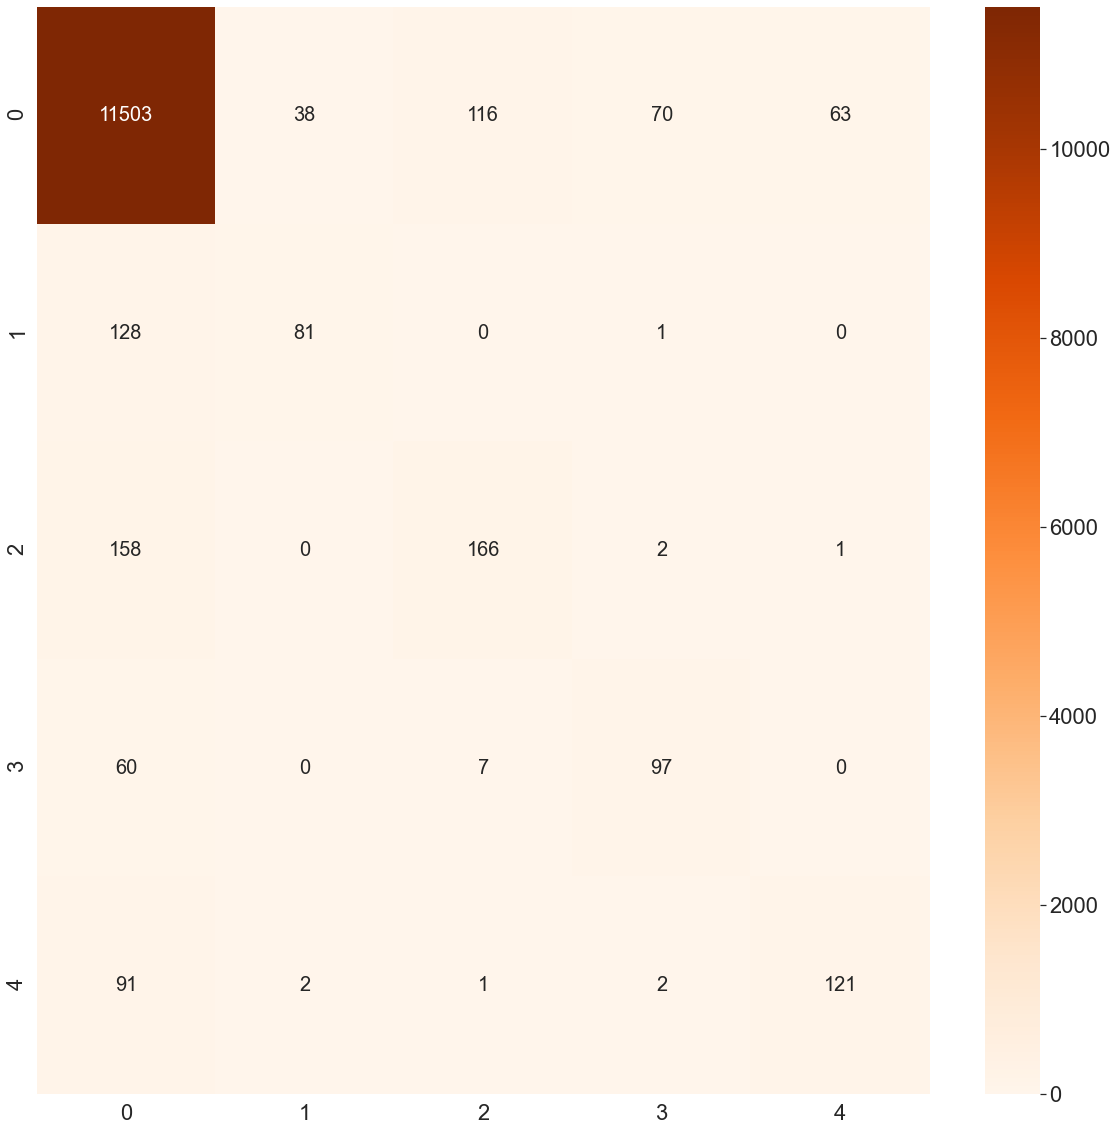

              precision    recall  f1-score   support

           0      0.963     0.976     0.969     11790
           1      0.669     0.386     0.489       210
           2      0.572     0.508     0.538       327
           3      0.564     0.591     0.577       164
           4      0.654     0.558     0.602       217

    accuracy                          0.942     12708
   macro avg      0.685     0.604     0.635     12708
weighted avg      0.938     0.942     0.939     12708



In [49]:
from sklearn import metrics
import seaborn as sn

# Print the confusion matrix
confusion = metrics.confusion_matrix(y_true, y_pred)
plt.figure(figsize = (20,20))
sn.set(font_scale=2) # for label size
sn.heatmap(confusion, annot=True, annot_kws={"size": 20}, cmap='Oranges', fmt='d') # font size
plt.show()

# Print the precision and recall, among other metrics
print(metrics.classification_report(y_true, y_pred, digits=3))

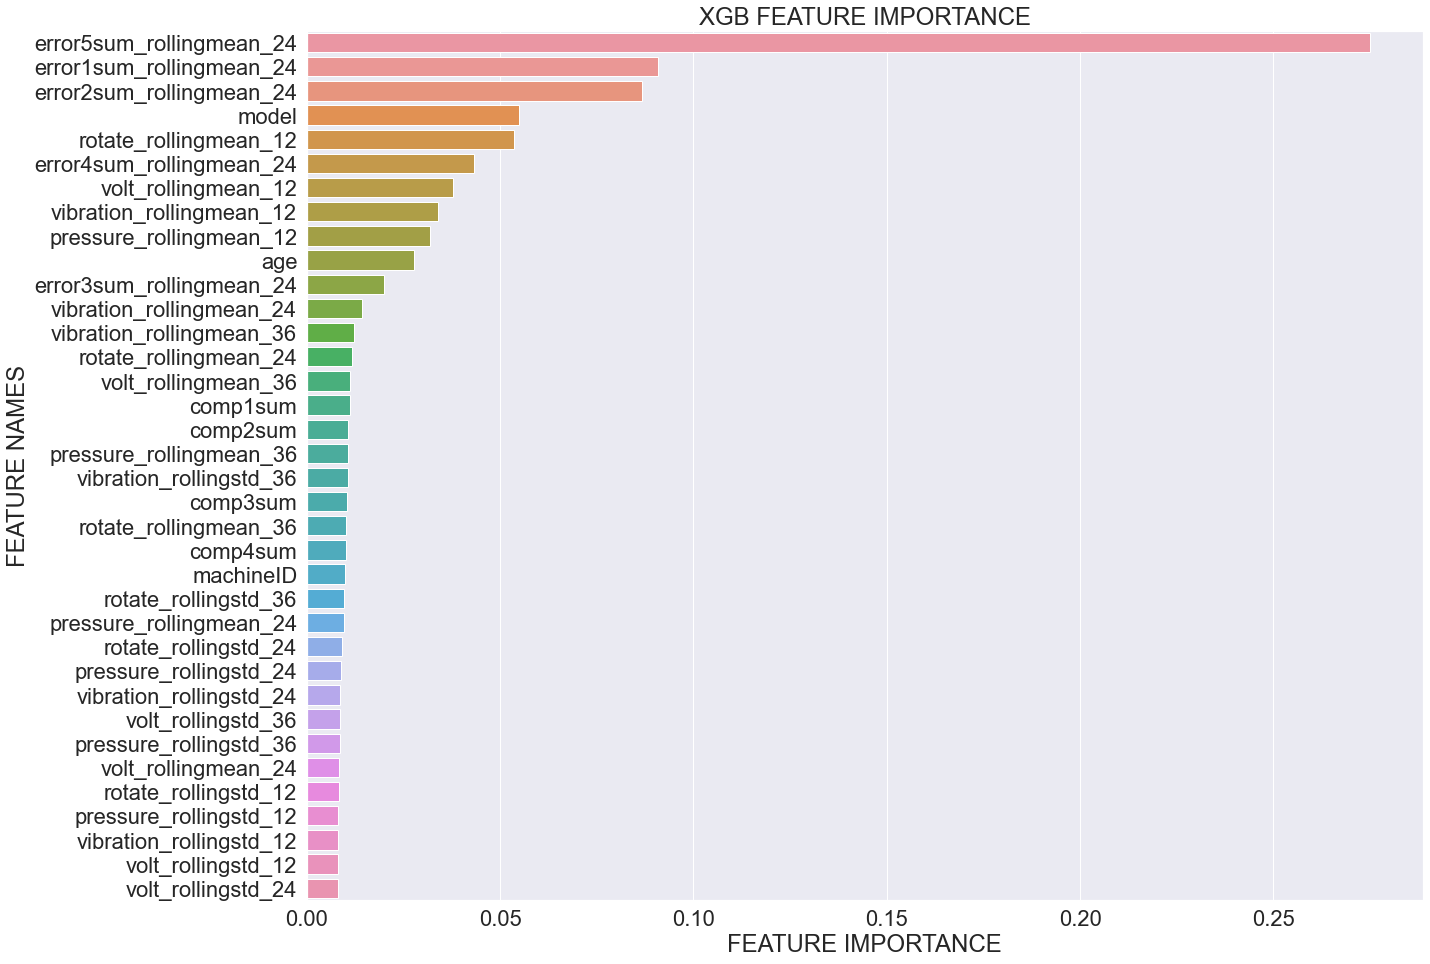

In [50]:
#print(model.feature_importances_)
plot_feature_importance(model.feature_importances_, input_features[:-1], 'XGB')

In [ ]:
train_ = train_data.toPandas()
test_ = test_data.toPandas()

X_train = train_.iloc[:,:-1]
y_train = train_.iloc[:,-1]
X_test = test_.iloc[:,:-1]
y_test = test_.iloc[:,-1]

param_dict = {'learning_rate': np.arange(0.0, 0.55, 0.025),
              'max_depth': np.arange(10, 105, 5),
              'n_estimators': [50, 75, 100, 125, 150],
              'grow_policy':['depthwise', 'lossguide'],
              'objective': ['multi:softmax'],
              'booster': ['gbtree'],
              'num_classes': [5],
              'subsample': np.arange(0.8, 1.05, 0.05),
              'reg_lambda': np.arange(0.5, 2.05, 0.1)}

xgb_clf = xgb.XGBClassifier()
# scoring = 'recall_micro'
# scoring = 'balanced_accuracy'
# scoring = 'average_precision'
# scoring = 'roc_auc_ovo'
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=1, random_state=0)
clf_random = RandomizedSearchCV(estimator = xgb_clf, param_distributions = param_dict, 
                                n_iter = 40, scoring = 'f1_macro', cv = cv,
                                n_jobs = 4, random_state = 0, verbose = 1)

clf_random.fit(X_train, y_train)
model = clf_random.best_estimator_
print("Best parameter: ", clf_random.best_params_)
print("Best score: ", clf_random.best_score_)

Fitting 5 folds for each of 40 candidates, totalling 200 fits


[Parallel(n_jobs=4)]: Using backend LokyBackend with 4 concurrent workers.


In [158]:
test_data.cache();

def get_prediction(stream_text):
    try:
    # filter the tweets whose length is greater than 0
        stream_text = stream_text.filter(lambda x: len(x) > 0)
        test_ = test_data.toPandas()
        X_test = test_.iloc[:,:-1]
    # create a dataframe with column name 'tweet' and each row will contain the tweet
        arr = stream_text.collect()[0].split(',')
        arr = [float(item) for item in arr]
        rowPd = pd.Series(arr, index=X_test.columns)
    # create a spark dataframe
        X_test = X_test.append(rowPd, ignore_index=True)
        item = X_test.iloc[[-1]]
    # transform the data using the pipeline and get the predicted sentiment
        prediction = model.predict(item) 
        print('prediction: ', prediction)
    except : 
        print('No data')
        
print(X_test[X_test.index.isin([0])].to_csv(index=False,header=False))
print(X_test[X_test.index.isin([42])].to_csv(index=False,header=False))
#print(X_test.iloc[42]) #print(X_test.iloc[[42]])
#print(X_test.columns)
#test = model.predict(X_test.iloc[[42]])

172.08392828934112,453.57689676650034,101.3031104455655,40.627410416221046,169.2308783490108,451.0073063600377,100.48725938881095,40.839261969577514,167.33960244902582,41.538493843692386,449.9630999087956,101.23008690091461,0.9502766481609554,3.554263836013955,0.438675238884377,0.21112228109019965,0.5468398426386494,3.997340620873914,0.38416787399272423,0.12543521853597545,0.4409257134568003,3.3723709834925955,0.19064779543044583,0.0642151875781272,60,0.0,0.0,0.0,0.0,0.0,579.0,534.0,474.0,459.0,4,3.0,0.0

168.78451750786107,361.2584232147353,99.7543314741395,38.29666654352845,168.59981661599514,403.185519903162,101.11490497284537,39.14190927153322,169.02575104137563,39.94057956530015,419.20935361543394,100.81229344040428,2.0954860479387296,8.908381758270494,0.6826009880627812,0.48979215480113464,0.5611691422593653,6.019703061426799,0.18844423646974595,0.1398317207227039,0.3074144963167534,1.3910275912440397,0.2729813462347151,0.11292722089345567,60,0.0,0.0,0.0,0.0,0.0,558.0,513.0,453.0

In [159]:
from pyspark.streaming import StreamingContext
from pyspark import SparkContext

# initialize the streaming context 
sc = SparkContext.getOrCreate()
ssc = StreamingContext(sc, batchDuration= 3)

# Create a DStream that will connect to hostname:port, like localhost:9991, nc -L -p 9991
lines = ssc.socketTextStream("localhost", 9981)

# split the tweet text by a keyword '_' so that we can identify which set of words is from a single item
words = lines.flatMap(lambda line : line.split('_'))

# get the predicted sentiments for the tweets received
words.foreachRDD(get_prediction)

# Start the computation
ssc.start()             

# Wait for the computation to terminate
ssc.awaitTerminationOrTimeout(30)
ssc.stop(stopSparkContext = False)

No data
prediction:  [2]
No data
prediction:  [0]
No data
No data
No data
No data
No data
No data
